In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
from tqdm.auto import tqdm as tqdm
import os, sys, pickle
from plotnine import *
sys.path.append('..')

In [3]:
output_rootdir = 'outputs/'

### Neural Data Imports + Processing

The easiest method to access and parse the neural data is through the loading of a dedicated dataset object. This object contains the image set, neural responses and associated metadata for each neural dataset on file. Here, we'll load the AllenBrainObservatory dataset (an optical physiology dataset) and triangulate our target neurons with a number of subsets. 

In [4]:
sys.path.append('neural_data')
from neural_data import *

In [5]:
neural_data = AllenBrainObservatory()

The neural data is divided into two dataframes, both indexed by the unique ID of each neuron (called in this case, the *cell_specimen_id*). The columns in the response data correspond to each of the images in the dataset (in this case, 119); each (row, column) combination is the mean response of the neuron (row) to the image (column). The columns of the meta data correspond to various properties of the target neurons (their location, their reliability, et cetera.)

In [6]:
neural_data.cell_responses.shape, neural_data.cell_metadata.shape

((39317, 119), (39317, 15))

The most sensible subsets we've prepackaged in the dataset object; we can see our options as follows:

In [7]:
neural_data.get_cell_subset_options()

{'signficant_running': 'return cells significantly modulated by running',
 'image_selective': 'return cells significantly modulated by natural scenes',
 'splithalf_r': 'return cells past a set threshold of splithalf reliability'}

Let's select a few of these options and pass them as arguments to a function for subsetting the larger dataset.

In [8]:
cell_subset_args = {'significant_running': False, 'image_selective': True, 'splithalf_r': 0.8}
cell_subset = neural_data.get_cell_subset(cell_subset_args, return_subset = True)

After applying our subset, we should have fewer neurons:

In [9]:
len(cell_subset), neural_data.cell_responses.loc[cell_subset, :].shape, neural_data.cell_metadata.loc[cell_subset, :].shape

(6619, (6619, 119), (6619, 15))

Let's save our subsetted dataframes for later use, resetting the index of our metadata for easier merging operations:

In [10]:
cell_response_subset = neural_data.cell_responses.loc[cell_subset, :]
cell_data = neural_data.cell_metadata.loc[cell_subset, :].reset_index()

The stimulus set (consisting of 118 natural scenes and 1 grey screen) can be loaded (and inspected) as follows:

In [11]:
stimulus_set = neural_data.stimulus_set

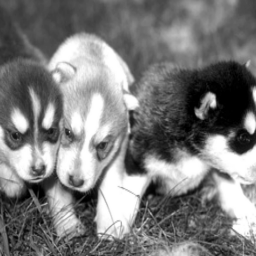

In [12]:
neural_data.view_sample_stimulus()

### Deep Net Features: Extraction

We've created tools that facilitate feature extraction on almost any feedforward Pytorch architecture. In the example here, we'll be showing an example of a model whose call we've prepackaged as part of a running list to accelerate multiple model comparisons.

In [13]:
sys.path.append('model_opts')
from feature_extraction import *
from model_options import *

In [14]:
model_options = get_model_options(model_source = 'torchvision')

Notice the full list includes both the Torchvision (PyTorch) model zoo, and the taskonomy models.

In [15]:
list(model_options.keys())[1::15]

['alexnet_imagenet',
 'vgg19_bn_random',
 'squeezenet1_1_imagenet',
 'mobilenet_v2_random',
 'fasterrcnn_resnet50_fpn_segmentation']

We also include a number of standard image transforms, of which we most commonly use *imagenet_from_numpy*.

In [16]:
list(get_image_transforms())

['imagenet_from_numpy', 'imagenet']

To use any of these models, we simply construct a call from the model_string, as follows:

In [17]:
model_string = 'resnet18_imagenet'

In [18]:
model_name = model_options[model_string]['model_name']
train_type = model_options[model_string]['train_type']
model_call = model_options[model_string]['call']
image_transforms = get_image_transforms()['imagenet_from_numpy']

Notice here the structure of the model call string, which is the piece of code we evaluate to load the model.

In [19]:
model_name, train_type, model_call

('resnet18', 'imagenet', 'models.resnet18(pretrained=True)')

In [20]:
model = eval(model_call)
model = model.eval()
if torch.cuda.is_available():
    model = model.cuda()

Next, we transform the stimulus set into a Torch variable and apply the relevant transforms, which we then pass into a convenience function we wrote based on [torchsummary](https://github.com/sksq96/pytorch-summary) that automatically extracts the features from each layer, returning an Ordered dictionary.

In [21]:
model_inputs = Variable(torch.stack([image_transforms(img) for img in stimulus_set]))
feature_maps = get_all_feature_maps(model, model_inputs)

Each entry in this dictionary is an array corresponding to the number of stimuli by the number of flattened activations in that layer.

In [22]:
feature_maps['Conv2d-1'].shape

(119, 802816)

For the purposes of this demonstration, we'll subset from this dictionary every 2nd convolutional layer, starting with the first.

In [23]:
feature_maps = {map_key: map_item  for (map_key, map_item) in feature_maps.items() 
                      if 'Conv' in map_key and int(map_key[-1]) % 2 == 1}

### Deep Net Features: Dimensionality Reduction

Once we've extracted our model features (activations), we generally need to reduce their dimensionality. Here, we show how to extract sparse random projections from the feature maps corresponding to each model layer.

In [24]:
sys.path.append('model_opts')
from feature_reduction import *

The Johnson-Lindenstraus lemma tells us how many projections to draw based on the number of samples in our dataset -- in this case, 119 -- for a certain quality of representation. We use [scikit-learn](https://scikit-learn.org/stable/modules/random_projection.html)'s default embedding quality of 0.1

In [25]:
n_projections = johnson_lindenstrauss_min_dim(stimulus_set.shape[0], eps = 0.1)
print('Number of projections:', n_projections)

Number of projections: 4096


We then extract our projections using another wrapper function we've written to facilitate the process.

In [26]:
output_dir = os.path.join(output_rootdir, 'srp_arrays')
feature_maps_reduced = srp_extraction(model_string, feature_maps = feature_maps, output_dir = output_dir, 
                                      eps = 0.1, seed = 1, keep_feature_maps = True)

Computing 4096 SRPs for resnet18_imagenet on CPU...


  0%|          | 0/10 [00:00<?, ?it/s]

### Neural Regression

With our features extract and their dimensionality reduced, we turn first to neural regression, regressing these dimensionality reduced feature maps directly on the response data from each neuron.

In [27]:
sys.path.append('regression')
from neural_regression import *

In this regression (y ~ x), the regressand (y) is our neural data (6747 neurons, 119 responses per neuron); the regressors are the sparse random projections of each feature map per model layer (119 images, 4096 random projections per image).

In [28]:
feature_maps_reduced['Conv2d-1'].shape, cell_response_subset.shape

((119, 4096), (6619, 119))

In [29]:
method_desc = 'srp_ridge_{}_projections'.format(n_projections)
    
scoresheet_list = []
for model_layer_index, model_layer in enumerate(tqdm(feature_maps_reduced)):
    feature_map = feature_maps_reduced[model_layer]
    X, y = feature_map, cell_response_subset.to_numpy().transpose()
    score = neural_regression(X, y, regression = Ridge(alpha = 1.0), cv_splits='gcv')
    scoresheet = pd.DataFrame({'cell_specimen_id': cell_response_subset.index, 'score': score, 
                               'model': model_name, 'train_type': train_type, 
                               'model_layer': model_layer, 'model_layer_index': model_layer_index})
        
    scoresheet_list.append(scoresheet)
    
neural_reg_results = pd.concat(scoresheet_list).reset_index()

  0%|          | 0/10 [00:00<?, ?it/s]

We can now combine our regression scores per neuron with our metadata to better parse the results. Here we'll show an example where we parse our results by neural geography (cortical area), though this is just one of many options (cre line, imaging depth, et cetera).

In [30]:
target_cell_data_columns = ['cell_specimen_id','cortical_area']
neural_reg_results = neural_reg_results.merge(cell_data[target_cell_data_columns])

An important (though sometimes statistically treacherous) step in the parsing of the regression results is deciding just exactly how to summarise the results for a given model. Here, we'll summarise first by taking the mean score of a given model layer for all neurons in a given cortical area. We'll then select the max of the mean model layer scores for each cortical area. We'll then take another mean across these maxes and designate this as the overall score for our model.

Naturally, this can sometimes provide an advantage to models with more layers, but empirically we found this not to be the case, and there are additional steps not shown here (including precommitments or a 'max' cross-validated across odd or even splits of trials) that can diminish the potential negative impacts and biases introduced by this advantage.

In [31]:
mean_relevant_columns = ['model','train_type','cortical_area', 'model_layer', 'model_layer_index']
neural_reg_results_mean = (neural_reg_results.groupby(mean_relevant_columns)['score'].mean().reset_index())

Here's a plot showing the scores per model layer for each of the cortical areas:

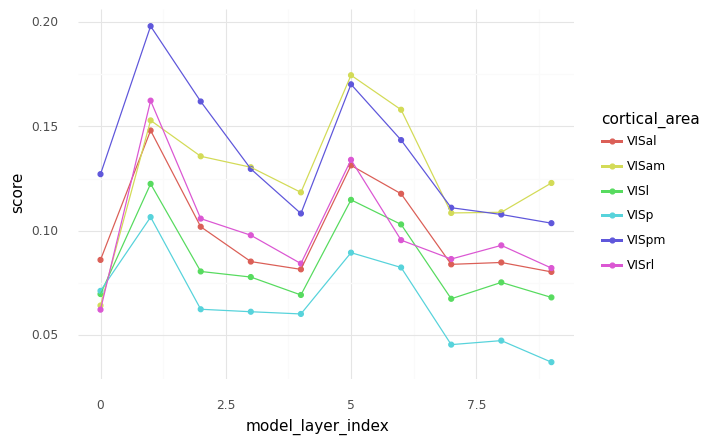

<ggplot: (8756744096317)>

In [32]:
(ggplot(neural_reg_results_mean, aes(x = 'model_layer_index', y = 'score', color = 'cortical_area')) + 
 geom_point() + geom_line(aes(group = 'cortical_area')) + theme_minimal())

Now, we take for each cortical area:

In [33]:
neural_reg_results_max = max_transform(neural_reg_results_mean, group_vars = ['cortical_area','model','train_type'])
neural_reg_results_max[['cortical_area','score']]

,cortical_area,score
0,VISal,0.148064
1,VISam,0.174588
2,VISl,0.122455
3,VISp,0.106499
4,VISpm,0.198123
5,VISrl,0.162383


Averaging over the max for each cortical area, our model's score is:

In [34]:
neural_reg_results_max['score'].mean()

0.15201840374097567

### Representational Similarity Analysis

We can further analyse our feature maps with representational similarity analysis. <br>
The first step in this procedure is the calculation of RDMs from our thresholded neural data. 

In [35]:
sys.path.append('similarity')
from rsa_methods import *

In [36]:
neural_rdms = neural_data.get_neural_rdms(subset = cell_subset, group_vars =['cortical_area'])

The second step is the calculation of RDMs from each layer of our target model.

In [37]:
model_rdms = {}
for model_layer in tqdm(feature_maps):
    model_rdms[model_layer] = np.corrcoef(feature_maps[model_layer])

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
neural_rdms['VISp'].shape, model_rdms['Conv2d-1'].shape

((119, 119), (119, 119))

We then systematically compare each of our model RDMs to each of target neural RDMs with a pearson correlation. (Notice, we use only the upper triangle of the RDM so as not to inflate our correlation scores.)

In [39]:
rsa_dict_list = []
for model_layer_index, model_layer in enumerate(tqdm(model_rdms)):
    model_layer_rdm = model_rdms[model_layer]
    for area in neural_rdms:
        neural_rdm = neural_rdms[area]
        score = compare_rdms(neural_rdm, model_layer_rdm)
        rsa_dict_list.append({'model': model_name, 'train_type': train_type, 'model_layer': model_layer, 
                              'model_layer_index': model_layer_index, 'cortical_area': area, 'score': score})
            
rsa_results = pd.DataFrame(rsa_dict_list)

  0%|          | 0/10 [00:00<?, ?it/s]

Here, we plot the representational similarity scores per layer per cortical area:

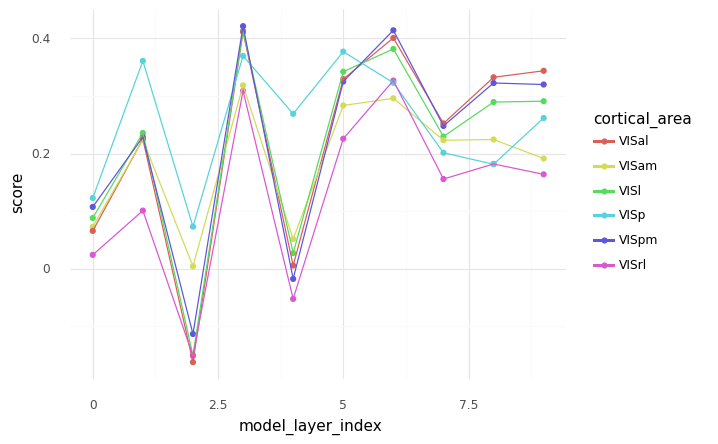

<ggplot: (8756735557845)>

In [40]:
(ggplot(rsa_results, aes(x = 'model_layer_index', y = 'score', color = 'cortical_area')) +
 geom_point() + geom_line(aes(group = 'cortical_area')) + theme_minimal())

And then once again we take the max across model layer:

In [41]:
rsa_results_max = max_transform(rsa_results, group_vars = ['model', 'train_type','cortical_area'])
rsa_results_max[['cortical_area','score']]

,cortical_area,score
0,VISl,0.413543
1,VISpm,0.421321
2,VISam,0.318499
3,VISal,0.411376
4,VISp,0.377049
5,VISrl,0.326866


Averaging over the max for each cortical area, our model's score is:

In [42]:
rsa_results_max['score'].mean()

0.3781089784939866

### Representational Similarity Regression

In [43]:
sys.path.append('similarity')
from rsa_methods import *

With a modified regression analysis in which negative coefficients are forbidden (called nonnegative least squares regression), we can use multiple RDMs simultaneously to predict a neural RDM. In this regression (y ~ x), the regressand (y) is the target neural RDM and the regressors are the stacked model RDMs from each layer.

In [44]:
model_rdm_stack = np.stack([model_rdms[model_layer] for model_layer in list(model_rdms.keys())], 2)

In [45]:
neural_rdms['VISp'].shape, model_rdm_stack.shape

((119, 119), (119, 119, 10))

We then combine this into a cross-validated nonnegative least squares regression as follows:

In [46]:
nnls_dict_list = []
for area in neural_rdms:
    neural_rdm = neural_rdms[area]
    score = kfold_nonnegative_regression(neural_rdm, model_rdm_stack, n_splits=6)[0]
    nnls_dict_list.append({'model': model_name, 'train_type': train_type,
                              'cortical_area': area, 'score': score})

nnlsrsa_results = pd.DataFrame(nnls_dict_list)

In [47]:
nnlsrsa_results[['cortical_area','score']]

,cortical_area,score
0,VISl,0.428340
1,VISpm,0.455686
2,VISam,0.348666
3,VISrl,0.307879
4,VISp,0.454622
5,VISal,0.449980


Averaging over all cortical areas, our model's score is:

In [48]:
nnlsrsa_results['score'].mean()

0.40752870843858463